[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiptos/is_notes/blob/main/nn_diabetes.ipynb)

# Prediction of Diabetes using ANN

The dataset is from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict whether a patient has diabetes based on diagnostic measurements. The dataset structure is the following:

    Pregnancies: Number of times pregnant
    Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
    BloodPressure: Diastolic blood pressure (mm Hg)
    SkinThickness: Triceps skin fold thickness (mm)
    Insulin: 2-Hour serum insulin (mu U/ml)
    BMI: Body mass index (weight in kg/(height in m)^2)
    DiabetesPedigreeFunction: Diabetes pedigree function
    Age: Age (years)
    Outcome: Class variable (0 or 1)

In [1]:
#importing Libraries
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Exploratory Data Analysis

Load the `diabetes.csv`dataset, that can be found in the `datasets` directory.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Check for null values:

In [3]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


Show a graph with the count of examples that are `negative` and that are `positive`. You can use the [`barplot`](https://seaborn.pydata.org/generated/seaborn.barplot.html) of the `Seaborn` module. You can use pandas' [`value_counts`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html) function.

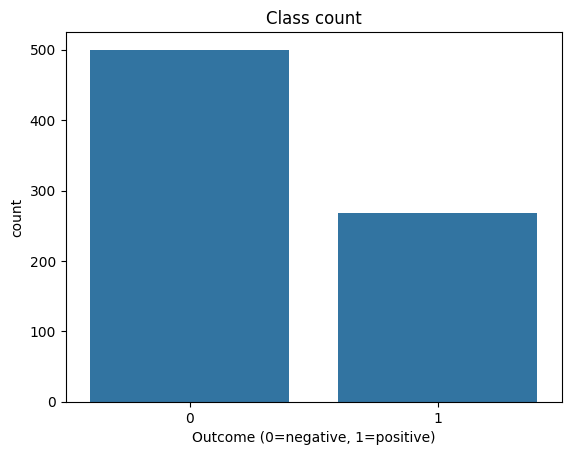

In [4]:
# 1) Conteggio negative/positive (Outcome)
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=df["Outcome"].value_counts().index.astype(str),
            y=df["Outcome"].value_counts().values)
plt.xlabel("Outcome (0=negative, 1=positive)")
plt.ylabel("count")
plt.title("Class count")
plt.show()


Draw a graph showing the distribution of glucose levels. You can use the [`displot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot).

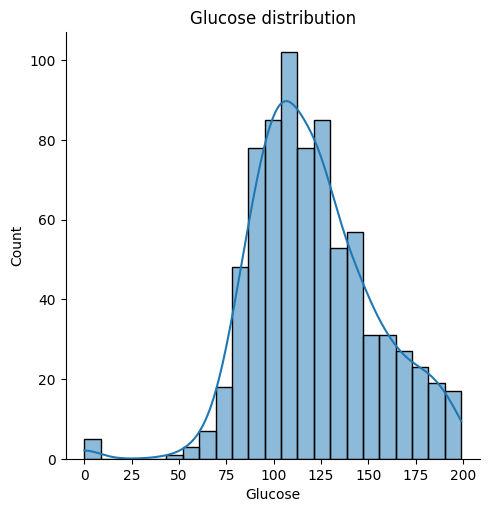

In [5]:
# 2) Distribuzione del Glucose
sns.displot(df, x="Glucose", kde=True)
plt.title("Glucose distribution")
plt.show()


Do the same for the Body Mass Index (BMI) and Blood Pressure.

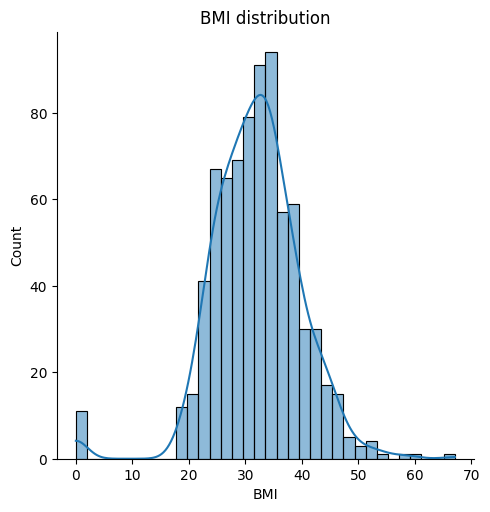

In [6]:
# 3) Distribuzione di BMI
sns.displot(df, x="BMI", kde=True)
plt.title("BMI distribution")
plt.show()

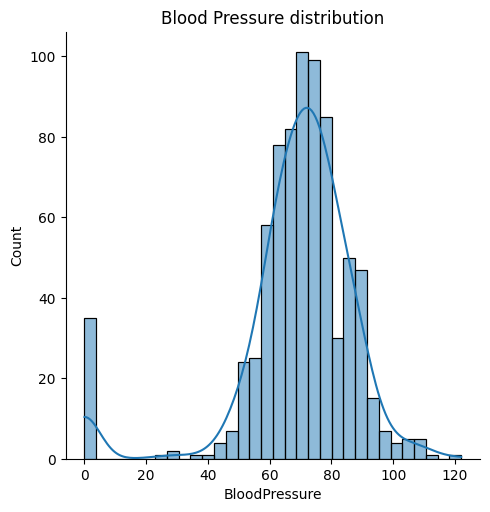

In [7]:
#    Distribuzione di BloodPressure
sns.displot(df, x="BloodPressure", kde=True)
plt.title("Blood Pressure distribution")
plt.show()

Draw a graph with the correlation between features ([`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot)).

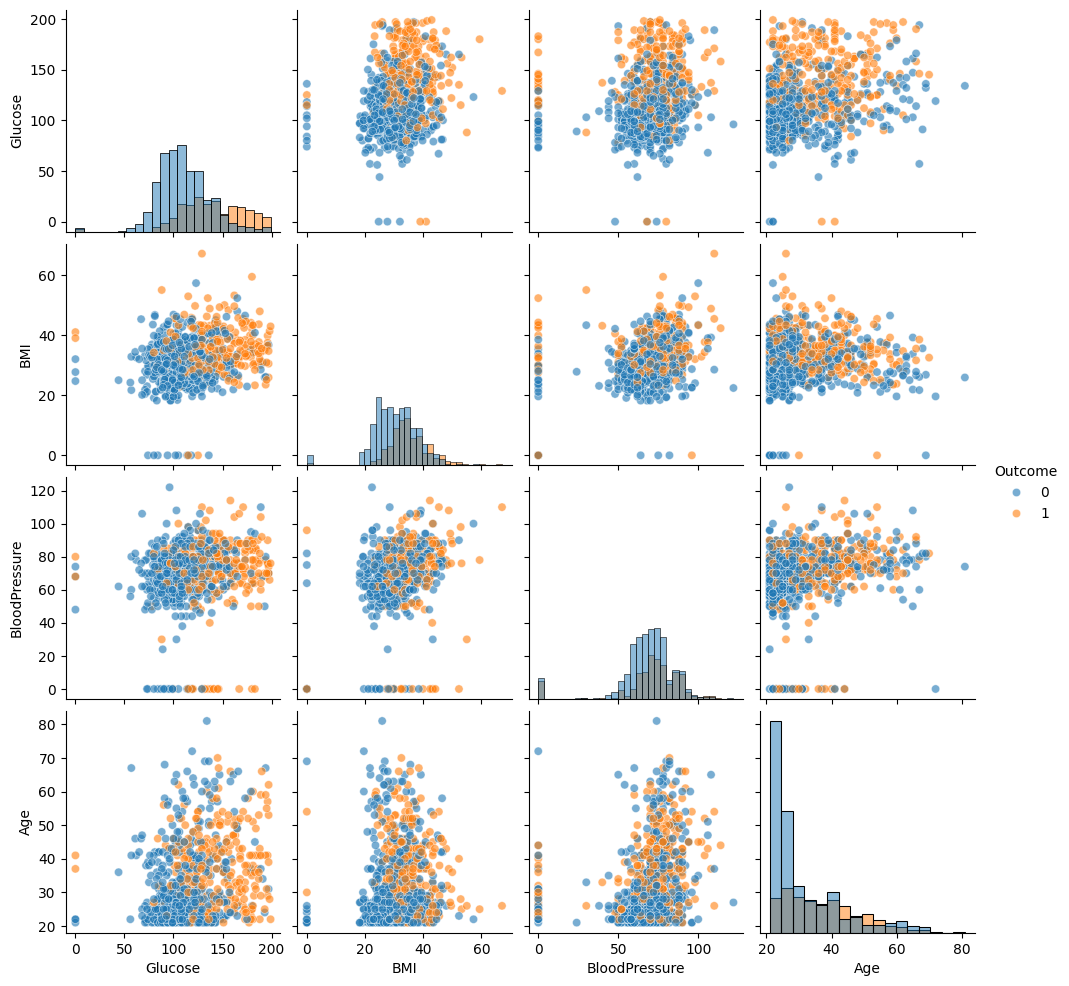

In [8]:
# 4) Correlazione tra feature (pairplot) con hue=Outcome
cols = ["Glucose", "BMI", "BloodPressure", "Age", "Outcome"]
sns.pairplot(df[cols], hue="Outcome", diag_kind="hist", plot_kws=dict(alpha=0.6))
plt.show()


## Training the model

Reload the dataset:

In [11]:
X,y = df(return_X_y=True, as_frame=True)

Split the dataset in two datasets: (X_train,y_train), with 80% of the examples and (X_test,y_test) with the remaining 20%. You can use [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

To be able to use PyTorch, it is necessary to create the [`tensor`](https://pytorch.org/docs/stable/tensors.html).

In [13]:
# Creating Tensors
X_train=torch.FloatTensor(X_train.values)
X_test=torch.FloatTensor(X_test.values)
y_train=torch.LongTensor(y_train.values)
y_test=torch.LongTensor(y_test.values)

### ANN class

Create the model using two linear hidden layers and one linear output layer. Also use ReLU activation function.

In [14]:

# --- ANN class ---
import torch
import torch.nn as nn

class ANN_model(nn.Module):
    def __init__(self, in_features, h1=32, h2=16, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)  # 2 logit (classe 0/1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)  # niente softmax: CrossEntropyLoss usa i logit


Instantiate the class.

In [16]:
# --- Instantiate ---
torch.manual_seed(20)
input_dim = X.shape[1]          # numero di feature
model = ANN_model(input_dim)


Confirm the architecture by printing the parameters:

In [17]:
# --- Confirm architecture (param shapes) ---
for n, p in model.named_parameters():
    print(f"{n:10s} -> {tuple(p.shape)}")


fc1.weight -> (32, 8)
fc1.bias   -> (32,)
fc2.weight -> (16, 32)
fc2.bias   -> (16,)
out.weight -> (2, 16)
out.bias   -> (2,)


Use [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss) as the loss function and the [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=adam#torch.optim.Adam) optimizer with  $lr=0.01$.

In [18]:
# Loss e Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


Train for 500 epocs.

In [20]:
# Training (500 epoche)
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).long()

epochs = 500
final_losses = []

model.train()
for i in range(1, epochs + 1):
    optimizer.zero_grad()
    y_pred = model(X_train_t)                 # logit (no softmax)
    loss = loss_function(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    final_losses.append(loss.item())
    if i % 50 == 0:
        print(f"epoch {i}: loss {loss.item():.4f}")


epoch 50: loss 0.5739
epoch 100: loss 0.5331
epoch 150: loss 0.5079
epoch 200: loss 0.4844
epoch 250: loss 0.4628
epoch 300: loss 0.4392
epoch 350: loss 0.4188
epoch 400: loss 0.4020
epoch 450: loss 0.4078
epoch 500: loss 0.3788


Plot the `final_losses` array to display the cost along the training.

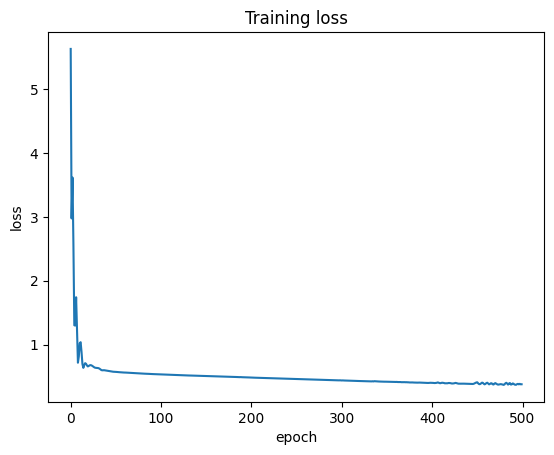

In [22]:
# Plot della loss
plt.plot(final_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()


Make the predictions on the `X_test` feature set and store the result in `predictions`.

In [24]:
# --- Predictions on X_test ---
# X_test_t = torch.from_numpy(X_test).float() # This line is no longer needed
model.eval()
with torch.no_grad():
    logits = model(X_test) # Use X_test directly
    predictions = logits.argmax(dim=1).cpu().numpy()

### Model evaluation

Display the confusion matrix using [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and Seaborn's [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

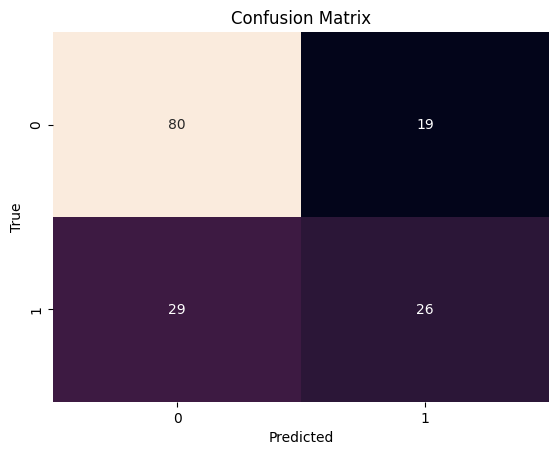

In [25]:
# --- Confusion matrix (with heatmap) ---
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


Finally, display the accuracy score ([`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)).

In [26]:
# --- Accuracy ---
print("Accuracy:", accuracy_score(y_test, predictions))


Accuracy: 0.6883116883116883
